# Comparación de Métodos Aproximados en MountainCar

Este notebook compara cuatro implementaciones de métodos basados en aproximaciones para resolver el escenario MountainCar-V0.

En concreto se mostrarán tres implementaciones de SARSA semi-gradiente con diferentes representaciones de características y la técnica Deep-Q-Learning:

1. **Fourier Basis Functions**
2. **Tile Coding**
3. **Radial Basis Functions (RBF)**
4. **Deep-Q-Learning**


In [ ]:
!pip install gymnasium
!pip install pygame

# Implementaciones de Agentes

In [7]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import multiprocessing

import subprocess
import os
import json
import glob
import pickle


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# -------------------- IMPLEMENTACIONES DE LOS AGENTES --------------------

class AgenteSARSASemiGradienteFourier:
    def __init__(self, env, alpha=0.01, gamma=1.0, epsilon=1.0, decay=True, fourier_order=3):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.fourier_order = fourier_order

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high
        self.state_dim = env.observation_space.shape[0]

        # Generar los coeficientes c para Fourier basis
        self.c = np.array(list(product(range(fourier_order + 1), repeat=self.state_dim)))
        self.d = len(self.c)

        # Una theta por acción
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    
    def guardar_agente(self, ruta_archivo="agente_sarsa_fourier.pkl"):
        """Guarda el agente SARSASemiGradienteFourier en un archivo pickle."""
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "fourier_order": self.fourier_order,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "c": self.c,
            "low": self.low,
            "high": self.high,
            "state_dim": self.state_dim,
            "nA": self.nA
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)
            
    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_fourier.pkl"):
        """Carga un agente SARSASemiGradienteFourier desde un archivo pickle."""
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)
    
        # Reconstruir el entorno
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
    
        agente = AgenteSARSASemiGradienteFourier(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            fourier_order=datos["fourier_order"]
        )
        
        # Restaurar parámetros
        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]
        agente.c = datos["c"]
        agente.low = datos["low"]
        agente.high = datos["high"]
        agente.state_dim = datos["state_dim"]
        agente.nA = datos["nA"]
    
        return agente

    def _scale_state(self, state):
        """Escala el estado continuo al rango [0, 1]"""
        return (state - self.low) / (self.high - self.low)

    def _phi(self, state):
        """Devuelve vector de características Fourier para un estado escalado"""
        s_scaled = self._scale_state(state)
        return np.cos(np.pi * np.dot(self.c, s_scaled))

    def _Q(self, state, action):
        """Valor aproximado Q(s, a)"""
        return np.dot(self.theta[action], self._phi(state))

    # -------------------- POLÍTICAS Y SELECCIÓN DE ACCIONES --------------------

    def seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy_fourier(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        """Selecciona una acción usando la política greedy."""
        q_values = [self._Q(state, a) for a in range(self.nA)]
        action = np.argmax(q_values)
        return action

    def _epsilon_soft_policy_fourier(self, state):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        return policy


    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
    
        acumulador_recompensas = 0.0
    
        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = min(1.0, 1000.0 / (t + 1))
    
            state, _ = self.env.reset()
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0
    
            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)
    
                phi = self._phi(state)
    
                if np.any(np.isnan(phi)) or np.any(np.isinf(phi)):
                    phi = np.nan_to_num(phi)
    
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                target = reward + self.gamma * q_next
                delta = target - q_current
    
                if np.isnan(delta) or np.isinf(delta):
                    delta = 0.0  # ignorar la actualización problemática
    
                # Update con control de valores extremos
                self.theta[action] += self.alpha * delta * phi
                self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)
    
                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1
    
            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))
    
        return self.theta

In [16]:
class RBFBasisFunctions:
    def __init__(self, low, high, num_centers=(5, 5), sigma=0.5):
        self.low = np.array(low)
        self.high = np.array(high)
        self.num_centers = np.array(num_centers)
        self.sigma = sigma

        # Normalizar límites para trabajar en [0, 1]
        self.range = self.high - self.low

        # Crear centros normalizados en grilla regular
        pos_centers = np.linspace(0, 1, num_centers[0])
        vel_centers = np.linspace(0, 1, num_centers[1])
        self.centers = np.array([[p, v] for p in pos_centers for v in vel_centers])

        self.num_features = len(self.centers)

    def normalize_state(self, state):
        return (np.array(state) - self.low) / self.range

    def get_features(self, state):
        state = self.normalize_state(state)
        features = np.exp(-np.sum((state - self.centers) ** 2, axis=1) / (2 * self.sigma ** 2))
        return features


class AgenteSARSARBF:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, num_centers=(5, 5), sigma=0.5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high

        self.rbf = RBFBasisFunctions(self.low, self.high, num_centers, sigma)
        self.d = self.rbf.num_features
        self.theta = np.zeros((self.nA, self.d))

        self.stats = []
        self.episode_lengths = []
    
    def guardar_agente(self, ruta_archivo="agente_sarsa_rbf.pkl"):
        """Guarda el agente AgenteSARSARBF en un archivo pickle."""
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "num_centers": self.rbf.num_centers,
            "sigma": self.rbf.sigma,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "low": self.low,
            "high": self.high
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)
            
    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_rbf.pkl"):
        """Carga un agente AgenteSARSARBF desde un archivo pickle."""
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)
    
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
    
        agente = AgenteSARSARBF(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            num_centers=tuple(datos["num_centers"]),
            sigma=datos["sigma"]
        )
    
        # Restaurar parámetros
        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]
        agente.low = datos["low"]
        agente.high = datos["high"]
    
        return agente

    def _phi(self, state):
        return self.rbf.get_features(state)

    def _Q(self, state, action):
        return np.dot(self.theta[action], self._phi(state))

    def _epsilon_soft_policy_rbf(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        q_values = np.nan_to_num(q_values)

        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        policy = np.clip(policy, 0, 1)
        return policy / policy.sum() if policy.sum() > 0 else np.ones(self.nA) / self.nA

    def seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy_rbf(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        """Selecciona una acción usando la política greedy."""
        q_values = [self._Q(state, a) for a in range(self.nA)]
        action = np.argmax(q_values)
        return action


    def entrenar(self, num_episodes=5000, mostrar_barra=True, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset()
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)

                phi = self._phi(state)
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not np.isnan(delta) and not np.isinf(delta):
                    self.theta[action] += self.alpha * delta * phi
                    self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))


In [29]:
# Tile coder para MountainCar
class TileCoder:
    def __init__(self, low, high, bins=(10, 10), num_tilings=8, offsets=None):
        self.low = np.array(low)
        self.high = np.array(high)
        self.bins = np.array(bins)
        self.num_tilings = num_tilings
        self.tile_width = (self.high - self.low) / (self.bins - 1)
        self.tiles_per_tiling = int(np.prod(self.bins))

        if offsets is not None:
            self.offsets = offsets
        else:
            # Offsets regulares para reproducibilidad
            self.offsets = [
                (np.arange(len(self.low)) * i * self.tile_width / self.num_tilings)
                for i in range(num_tilings)
            ]

    def get_feature_indices(self, state):
        indices = []
        for i, offset in enumerate(self.offsets):
            shifted = state + offset
            idx = ((shifted - self.low) / self.tile_width).astype(int)
            idx = np.clip(idx, 0, self.bins - 1)
            tile_index = np.ravel_multi_index(idx, self.bins)
            indices.append(i * self.tiles_per_tiling + tile_index)
        return indices


class AgenteSARSATileCoding:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, bins=(8, 8), num_tilings=8, offsets=None):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.tile_coder = TileCoder(env.observation_space.low, env.observation_space.high, bins, num_tilings, offsets)
        self.d = self.tile_coder.tiles_per_tiling * num_tilings
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    def guardar_agente(self, ruta_archivo="agente_sarsa_tilecoding.pkl"):
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "bins": self.tile_coder.bins,
            "num_tilings": self.tile_coder.num_tilings,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "low": self.tile_coder.low,
            "high": self.tile_coder.high,
            "offsets": self.tile_coder.offsets
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)

    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_tilecoding.pkl"):
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)

        env = gym.make("MountainCar-v0")
        env.reset(seed=42)

        agente = AgenteSARSATileCoding(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            bins=tuple(datos["bins"]),
            num_tilings=datos["num_tilings"],
            offsets=datos["offsets"]
        )

        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]

        return agente

    def _Q(self, state, action):
        indices = self.tile_coder.get_feature_indices(state)
        return np.sum(self.theta[action, indices])

    def seleccionar_accion(self, state):
        policy = self._epsilon_soft_policy(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        q_values = [self._Q(state, a) for a in range(self.nA)]
        return np.argmax(q_values)

    def _epsilon_soft_policy(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        return policy

    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        from tqdm import tqdm
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset(seed=42)
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)

                indices = self.tile_coder.get_feature_indices(state)
                q_current = np.sum(self.theta[action, indices])
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not (np.isnan(delta) or np.isinf(delta)):
                    self.theta[action, indices] += self.alpha * delta
                    np.clip(self.theta[action, indices], -1e6, 1e6, out=self.theta[action, indices])

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.theta

In [45]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class AgenteDQLearning:
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 alpha=1e-3, gamma=0.99, buffer_size=100000, batch_size=64,
                 target_update_freq=1000):
        
        self.env = env
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_size)
        self.target_update_freq = target_update_freq

        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(self.nS, self.nA).to(self.device)
        self.target_net = DQN(self.nS, self.nA).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.alpha)
        self.stats = []
        self.episode_lengths = []
        self.steps_done = 0

    def guardar_agente(self, name="agente_dqn.pkl"):
        # Crear un diccionario con todo lo importante
        modelo_guardado = {
            "params": {
                "alpha": self.alpha,
                "gamma": self.gamma,
                "epsilon": self.epsilon,
                "epsilon_min": self.epsilon_min,
                "epsilon_decay": self.epsilon_decay,
                "buffer_size": self.buffer.maxlen,
                "batch_size": self.batch_size,
                "target_update_freq": self.target_update_freq,
            },
            "policy_state_dict": self.policy_net.state_dict(),
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
        }
        
        # Guardar en un archivo
        with open(name, "wb") as f:
            pickle.dump(modelo_guardado, f)

    @staticmethod
    def cargar_agente(name="agente_dqn.pkl"):
        # Cargar el archivo
        with open(name, "rb") as f:
            data = pickle.load(f)
        
        # Reconstruir el entorno
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
        
        # Reconstruir el agente con los mismos hiperparámetros
        agent = AgenteDQLearning(env, **data["params"])
        agent.policy_net.load_state_dict(data["policy_state_dict"])
        agent.stats = data["stats"]
        agent.episode_lengths = data["episode_lengths"]
    
        return agent


    def seleccionar_accion(self, estado):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy(estado)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, estado):
        """Selecciona la mejor acción según la política actual (greedy)."""
        estado_tensor = torch.tensor(estado, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_vals = self.policy_net(estado_tensor)
        return torch.argmax(q_vals, dim=1).item()

    
    def _epsilon_soft_policy(self, estado):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        estado_tensor = torch.tensor(estado, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_vals = self.policy_net(estado_tensor).cpu().numpy().squeeze()
        
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_vals)
        policy[best_action] += 1.0 - self.epsilon
        return policy


    def almacenar(self, s, a, r, s_, done):
        self.buffer.append((s, a, r, s_, done))

    def _actualizar_red(self):
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.tensor(np.array(s), dtype=torch.float32).to(self.device)
        a = torch.tensor(np.array(a), dtype=torch.int64).unsqueeze(1).to(self.device)
        r = torch.tensor(np.array(r), dtype=torch.float32).unsqueeze(1).to(self.device)
        s_ = torch.tensor(np.array(s_), dtype=torch.float32).to(self.device)
        d = torch.tensor(np.array(d), dtype=torch.float32).unsqueeze(1).to(self.device)

        q_vals = self.policy_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1, keepdim=True)[0]
            target = r + self.gamma * q_next * (1 - d)

        loss = nn.MSELoss()(q_vals, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.env.reset(seed=SEED)
        self.env.action_space.seed(SEED)

        acumulador_recompensas = 0.0

        pbar = tqdm(range(num_episodes), desc="Entrenando", dynamic_ncols=True)
        
        for t in pbar:
            estado, _ = self.env.reset()
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                accion = self.seleccionar_accion(estado)
                estado_siguiente, recompensa, terminado, truncado, _ = self.env.step(accion)
                done = terminado or truncado

                self.almacenar(estado, accion, recompensa, estado_siguiente, done)
                self._actualizar_red()

                estado = estado_siguiente
                total_reward += recompensa
                pasos += 1
                self.steps_done += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

            pbar.set_postfix({'Recompensa': total_reward})
            
            # Epsilon decay
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return self.policy_net

# Funciones auxiliares

In [49]:
# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)


# -------------------- EVALUACIÓN DE LA POLÍTICA --------------------

def evaluar_politica(agente, num_episodios=100):
    """Evalúa la política del agente ejecutando múltiples episodios y muestra estadísticas."""

    env = agente.env
    recompensas = []
    longitudes = []
    semillas_fallidas = []

    pbar = tqdm(range(num_episodios), desc="Evaluando", dynamic_ncols=True)
    for i in pbar:
        random.seed(i)
        np.random.seed(i)
        env.action_space.seed(i)
        state, _ = env.reset(seed=i)
        done = False
        total_reward = 0
        posiciones = []
        pasos = 0

        terminated = False
        truncated = False
        
        while not done:
            posiciones.append(state[0])
            action = agente.seleccionar_accion_greedy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            pasos += 1
            
            if truncated:
                semillas_fallidas.append(i)
                
        recompensas.append(total_reward)
        longitudes.append(pasos)
        env.close()

    # Resumen estadístico
    print("📊 Resultados de evaluación:")
    print(f"  Episodios evaluados: {num_episodios}")
    print(f"  Recompensa media:    {np.mean(recompensas):.2f} ± {np.std(recompensas):.2f}")
    print(f"  Recompensa min/max:  {np.max(recompensas):.2f} / {np.min(recompensas):.2f}")

    print(f"  Episodios exitosos:  {num_episodios - len(semillas_fallidas)}")
    print(f"  Episodios fallidos:  {len(semillas_fallidas)}")
    print(f"  Semillas fallidas: {semillas_fallidas}")

# -------------------- GRABACIÓN DE EPISODIO --------------------

def grabar_video_agente(agente, seed, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agente.seleccionar_accion_greedy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

# Resultados experimentales

## Agente Sarsa-Semigradiente-Fourier 

Parámetros: 
- alpha=0.05
- gamma=1.0
- fourier_order=1
- decay=True

In [26]:
agente_fourier = AgenteSARSASemiGradienteFourier.cargar_agente("agente_sarsa_fourier.pkl")

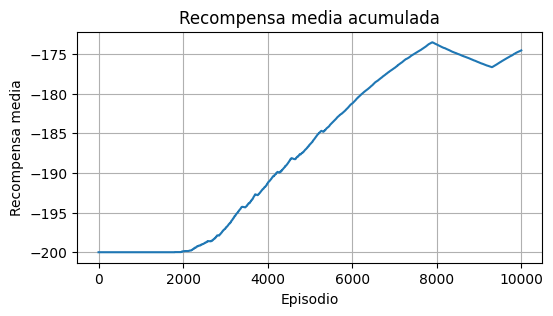

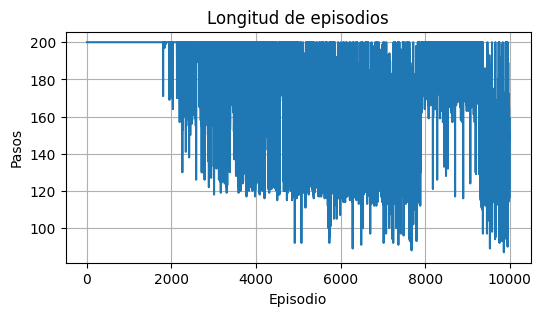

In [27]:
mostrar_resultados_agente_continuo(agente_fourier)

In [35]:
evaluar_politica(agente_fourier, num_episodios=10000)

Evaluando: 100%|█████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 117.85it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -139.02 ± 29.95
  Recompensa min/max:  -85.00 / -199.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [56]:
nombre_archivo = "video_mountaincar_fourier.gif"

grabar_video_agente(agente_fourier, seed=SEED, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 94
🎥 Vídeo guardado en: video_mountaincar_fourier.gif
🏁 Recompensa total obtenida: -94.00


## Agente Sarsa-Semigradiente-RBF

Parámetros: 
- alpha=0.01
- gamma=1.0
- epsilon=1.0
- num_centers=(9, 9)
- sigma=0.2
- decay=True

In [17]:
agente_rbf = AgenteSARSARBF.cargar_agente("agente_sarsa_rbf.pkl")

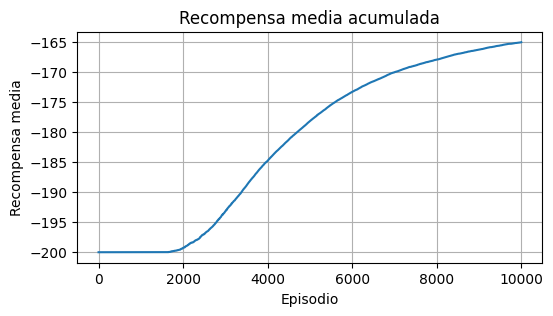

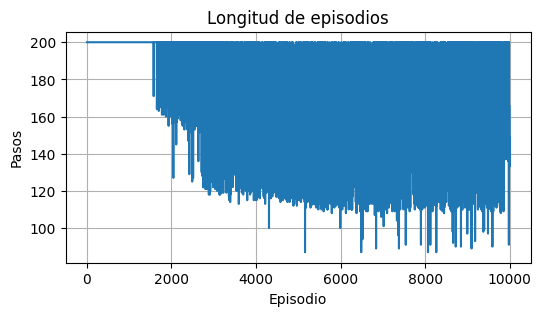

In [18]:
mostrar_resultados_agente_continuo(agente_rbf)

In [36]:
evaluar_politica(agente_rbf, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [02:29<00:00, 66.78it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -150.10 ± 16.42
  Recompensa min/max:  -108.00 / -191.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [57]:
nombre_archivo = "video_mountaincar_rbf.gif"

grabar_video_agente(agente_rbf, seed=SEED, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 153
🎥 Vídeo guardado en: video_mountaincar_rbf.gif
🏁 Recompensa total obtenida: -153.00


## Agente Sarsa-Semigradiente-TileCoding

Parámetros:

- alpha=0.01
- gamma=1.0
- epsilon=0.1
- decay=False
- bins=(8, 8)
- num_tilings=8

In [31]:
agente_tilecoding = AgenteSARSATileCoding.cargar_agente("agente_sarsa_tilecoding.pkl")

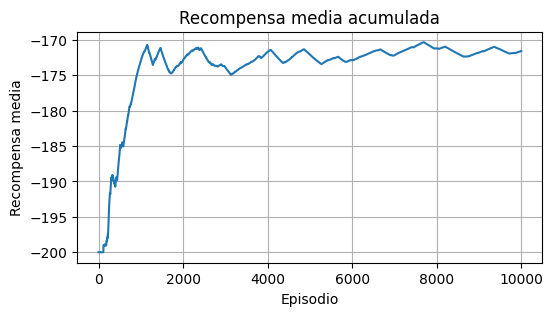

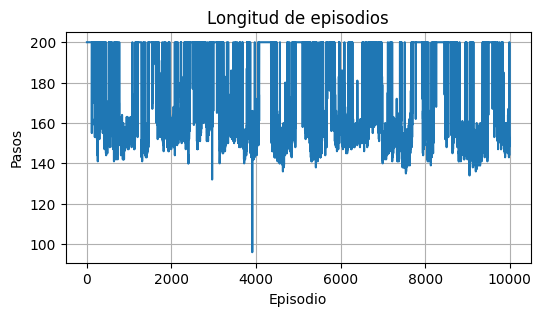

In [32]:
mostrar_resultados_agente_continuo(agente_tilecoding)

In [37]:
evaluar_politica(agente_tilecoding, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [12:43<00:00, 13.09it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -145.76 ± 16.38
  Recompensa min/max:  -88.00 / -189.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [58]:
nombre_archivo = "video_mountaincar_tilecoding.gif"

grabar_video_agente(agente_tilecoding, seed=SEED, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 160
🎥 Vídeo guardado en: video_mountaincar_tilecoding.gif
🏁 Recompensa total obtenida: -160.00


## Agente Deep-Q-Learning

Parámetros:

- alpha=0.001
- gamma=1.0
- epsilon=1.0

Red:

```python
DQN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True```)
  )
)


In [46]:
agente_dqn = AgenteDQLearning.cargar_agente("Deep-Q-Learning/agente_dqn.pkl")

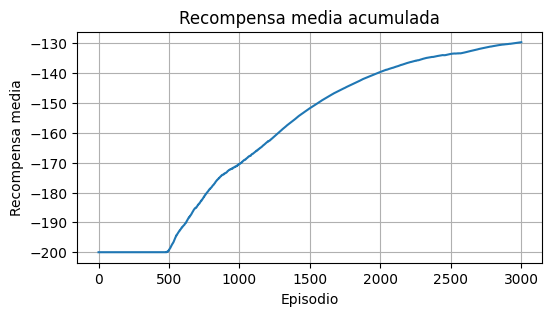

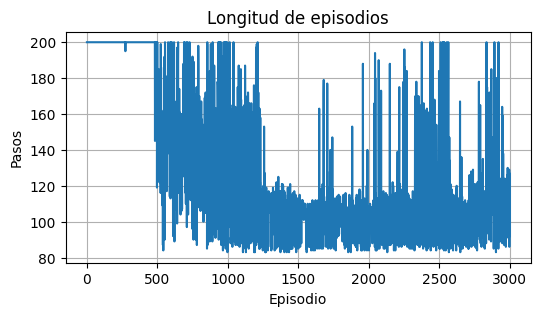

In [47]:
mostrar_resultados_agente_continuo(agente_dqn)

In [48]:
evaluar_politica(agente_dqn, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [12:13<00:00, 13.63it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -106.37 ± 11.19
  Recompensa min/max:  -87.00 / -130.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [59]:
nombre_archivo = "video_mountaincar_dqn.gif"

grabar_video_agente(agente_dqn, seed=SEED, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 93
🎥 Vídeo guardado en: video_mountaincar_dqn.gif
🏁 Recompensa total obtenida: -93.00
